# Кластеризация ЕГЭ (8.5 если сделаны все задачи)

Рядом лежат экселевские таблицы с координатами точек. В 3 и 4 задаче используется манхетеское расстояние. В остальных Евклидово.

* Постройте Распределение точек
* Кластеризуйте руками
* Постройте Распределение точек, отметьте принадлежность кластеров цветами
* Найдите среди в каждом кластере точку расстояние от которой до всех остальных минимально
* Выведите усреднение центров всех кластеров * 1000

Анализируемый набор содержит 100 точек

АНАЛИЗ КЛАСТЕРОВ ДЛЯ 0.xls

▶ Группа 1:
  Количество элементов: 50
  Наиболее центральная точка: (2.0339, 5.2893)
  Суммарное расстояние до остальных: 36.1534

▶ Группа 2:
  Количество элементов: 50
  Наиболее центральная точка: (0.0481, 8.0531)
  Суммарное расстояние до остальных: 43.2988


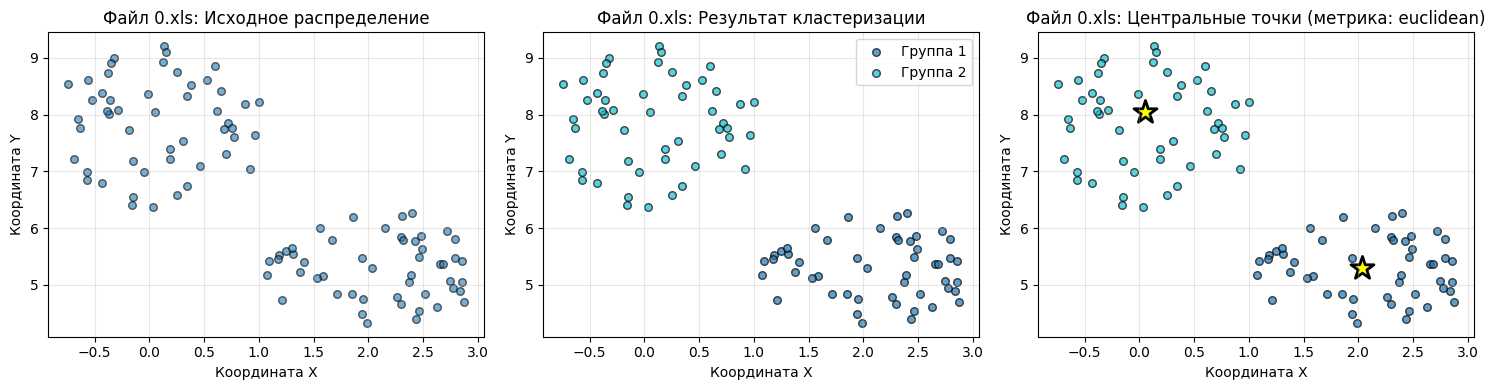


ИТОГОВЫЕ РЕЗУЛЬТАТЫ
  Среднее значение центроидов: (1.093471, 6.575711)
  Умноженное на 1000: (1093.47, 6575.71)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist, pdist, squareform

# Переименованные функции для вычисления матриц расстояний
def compute_euclidean_dist_mat(data_pts):
    """Вычисление евклидовых расстояний"""
    return squareform(pdist(data_pts, metric='euclidean'))

def compute_manhattan_dist_mat(data_pts):
    """Вычисление манхэттенских расстояний"""
    return squareform(pdist(data_pts, metric='cityblock'))

def locate_most_central(cluster_data, metric_type='euclidean'):
    """
    Поиск точки с минимальной суммой расстояний до всех других точек кластера
    """
    if metric_type == 'euclidean':
        dist_matrix = compute_euclidean_dist_mat(cluster_data)
    else:
        dist_matrix = compute_manhattan_dist_mat(cluster_data)
    
    sum_rows = dist_matrix.sum(axis=1)
    optimal_index = sum_rows.argmin()
    
    return cluster_data[optimal_index], sum_rows[optimal_index]

def kmeans_custom(dataset, cluster_count=3, metric_type='euclidean', max_loops=100):
    """
    Реализация алгоритма кластеризации
    """
    # Фиксируем seed для воспроизводимости
    np.random.seed(42)
    
    # Инициализация центроидов
    initial_indices = np.random.choice(len(dataset), cluster_count, replace=False)
    centroids = dataset[initial_indices]
    
    for iteration in range(max_loops):
        # Шаг 1: назначение точек кластерам
        if metric_type == 'euclidean':
            dist_to_centroids = cdist(dataset, centroids, metric='euclidean')
        else:
            dist_to_centroids = cdist(dataset, centroids, metric='cityblock')
        
        cluster_assignments = dist_to_centroids.argmin(axis=1)
        
        # Шаг 2: обновление центроидов
        updated_centroids = []
        for idx in range(cluster_count):
            cluster_members = dataset[cluster_assignments == idx]
            if len(cluster_members) > 0:
                updated_centroids.append(cluster_members.mean(axis=0))
            else:
                updated_centroids.append(centroids[idx])
        
        updated_centroids = np.array(updated_centroids)
        
        # Проверка сходимости
        if np.allclose(centroids, updated_centroids, rtol=1e-4):
            break
            
        centroids = updated_centroids
    
    return cluster_assignments, centroids

def process_clustering(data_frame, metric_type='euclidean', file_ref='', num_clusters=1):
    """
    Основная функция кластеризации и визуализации
    """
    # Извлечение координат
    if 'X' in data_frame.columns and 'Y' in data_frame.columns:
        coordinates = data_frame[['X', 'Y']].values
    else:
        numeric_data = data_frame.select_dtypes(include=[np.number]).columns
        coordinates = data_frame[numeric_data[:2]].values
    
    print(f"Анализируемый набор содержит {len(coordinates)} точек")
    
    # Создание фигуры с тремя подграфиками
    fig = plt.figure(figsize=(15, 4))
    
    # График 1: исходные данные
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.scatter(coordinates[:, 0], coordinates[:, 1], s=30, alpha=0.6, edgecolors='k')
    ax1.set_title(f'Файл {file_ref}: Исходное распределение')
    ax1.set_xlabel('Координата X')
    ax1.set_ylabel('Координата Y')
    ax1.grid(True, alpha=0.3)
    
    # Выполнение кластеризации
    labels, centers = kmeans_custom(coordinates, cluster_count=num_clusters, metric_type=metric_type)
    
    # График 2: результат кластеризации
    ax2 = fig.add_subplot(1, 3, 2)
    color_map = plt.cm.tab10(np.linspace(0, 1, num_clusters))
    
    for cluster_idx in range(num_clusters):
        cluster_data = coordinates[labels == cluster_idx]
        if len(cluster_data) > 0:
            ax2.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                       s=30, alpha=0.7, color=color_map[cluster_idx], 
                       edgecolors='k', label=f'Группа {cluster_idx + 1}')
    
    ax2.set_title(f'Файл {file_ref}: Результат кластеризации')
    ax2.set_xlabel('Координата X')
    ax2.set_ylabel('Координата Y')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Поиск центральных точек в кластерах
    central_points = []
    point_distances = []
    
    print("\n" + "="*50)
    print(f"АНАЛИЗ КЛАСТЕРОВ ДЛЯ {file_ref}")
    print("="*50)
    
    for cluster_idx in range(num_clusters):
        cluster_members = coordinates[labels == cluster_idx]
        if len(cluster_members) > 0:
            central_pt, sum_dist = locate_most_central(cluster_members, metric_type=metric_type)
            central_points.append(central_pt)
            point_distances.append(sum_dist)
            
            print(f"\n▶ Группа {cluster_idx + 1}:")
            print(f"  Количество элементов: {len(cluster_members)}")
            print(f"  Наиболее центральная точка: ({central_pt[0]:.4f}, {central_pt[1]:.4f})")
            print(f"  Суммарное расстояние до остальных: {sum_dist:.4f}")
        else:
            central_points.append(None)
            point_distances.append(0)
            print(f"\n▶ Группа {cluster_idx + 1}: пустая")
    
    # График 3: с выделенными центральными точками
    ax3 = fig.add_subplot(1, 3, 3)
    
    for cluster_idx in range(num_clusters):
        group_members = coordinates[labels == cluster_idx]
        if len(group_members) > 0:
            ax3.scatter(group_members[:, 0], group_members[:, 1], 
                       s=30, alpha=0.7, color=color_map[cluster_idx], 
                       edgecolors='k', label=f'Группа {cluster_idx + 1}')
            
            if central_points[cluster_idx] is not None:
                ax3.scatter(central_points[cluster_idx][0], central_points[cluster_idx][1], 
                          s=300, marker='*', c='yellow', edgecolors='k', 
                          linewidth=2, label=f'Центр группы {cluster_idx + 1}' if cluster_idx == 0 else "")
    
    ax3.set_title(f'Файл {file_ref}: Центральные точки (метрика: {metric_type})')
    ax3.set_xlabel('Координата X')
    ax3.set_ylabel('Координата Y')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Финальные вычисления
    avg_center_coords = centers.mean(axis=0)
    scaled_coords = avg_center_coords * 1000
    
    print("\n" + "="*50)
    print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
    print("="*50)
    print(f"  Среднее значение центроидов: ({avg_center_coords[0]:.6f}, {avg_center_coords[1]:.6f})")
    print(f"  Умноженное на 1000: ({scaled_coords[0]:.2f}, {scaled_coords[1]:.2f})")
    print("="*50)

# Вызов функции
input_data = pd.read_excel("0.xls")
process_clustering(input_data, 'euclidean', "0.xls", 2)

Анализируемый набор содержит 9999 точек

АНАЛИЗ КЛАСТЕРОВ ДЛЯ 1.xls

▶ Группа 1:
  Количество элементов: 3333
  Наиболее центральная точка: (10.0225, 1.1542)
  Суммарное расстояние до остальных: 2456.7758

▶ Группа 2:
  Количество элементов: 3333
  Наиболее центральная точка: (8.0401, -1.1087)
  Суммарное расстояние до остальных: 3177.1591

▶ Группа 3:
  Количество элементов: 3333
  Наиболее центральная точка: (6.4700, 2.1698)
  Суммарное расстояние до остальных: 3086.3168


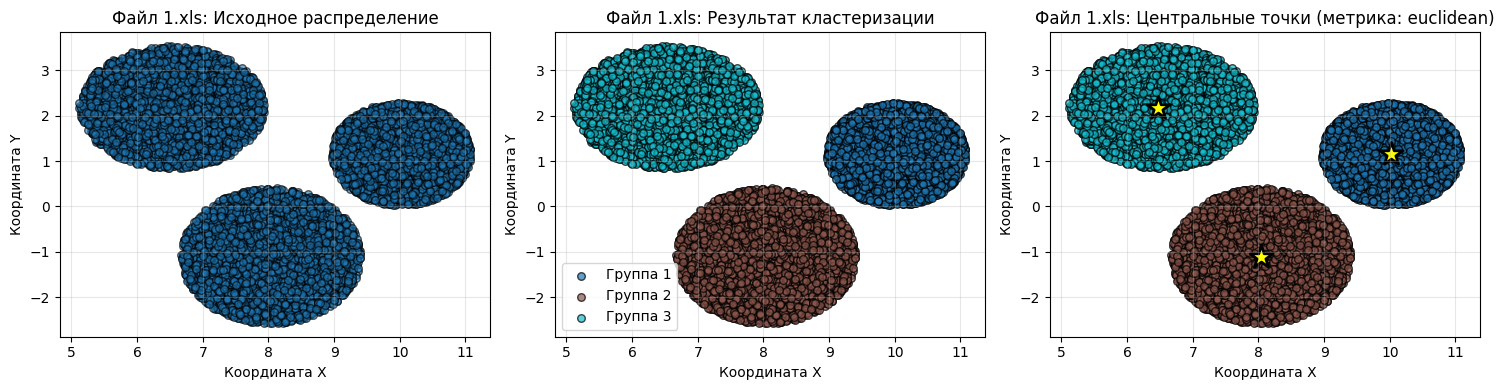


ИТОГОВЫЕ РЕЗУЛЬТАТЫ
  Среднее значение центроидов: (8.187203, 0.743485)
  Умноженное на 1000: (8187.20, 743.48)


In [2]:
process_clustering(pd.read_excel("1.xls"), 'euclidean', "1.xls", 3)

Анализируемый набор содержит 999 точек

АНАЛИЗ КЛАСТЕРОВ ДЛЯ 2.xlsx

▶ Группа 1:
  Количество элементов: 524
  Наиболее центральная точка: (34.9264, -4.6953)
  Суммарное расстояние до остальных: 3092.4875

▶ Группа 2:
  Количество элементов: 475
  Наиболее центральная точка: (11.3341, 5.9660)
  Суммарное расстояние до остальных: 2811.4686


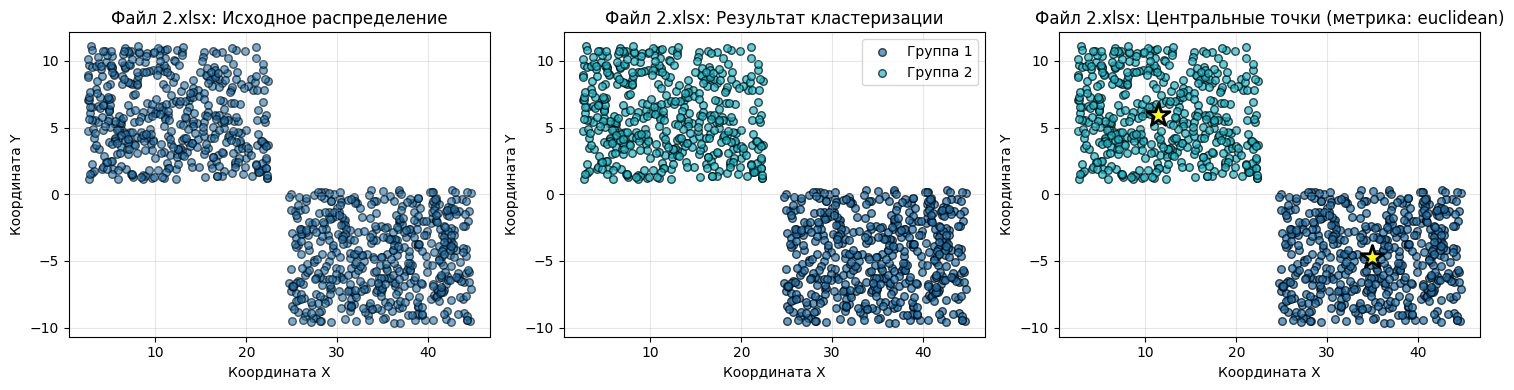


ИТОГОВЫЕ РЕЗУЛЬТАТЫ
  Среднее значение центроидов: (23.387758, 0.645643)
  Умноженное на 1000: (23387.76, 645.64)


In [4]:
process_clustering(pd.read_excel("2.xlsx"), 'euclidean', "2.xlsx", 2)

Анализируемый набор содержит 9999 точек

АНАЛИЗ КЛАСТЕРОВ ДЛЯ 3.xlsx

▶ Группа 1:
  Количество элементов: 3287
  Наиболее центральная точка: (30.8495, -4.5172)
  Суммарное расстояние до остальных: 24365.7355

▶ Группа 2:
  Количество элементов: 3428
  Наиболее центральная точка: (-25.1308, -14.4133)
  Суммарное расстояние до остальных: 25620.9224

▶ Группа 3:
  Количество элементов: 3284
  Наиболее центральная точка: (3.5179, 4.6537)
  Суммарное расстояние до остальных: 24396.1320


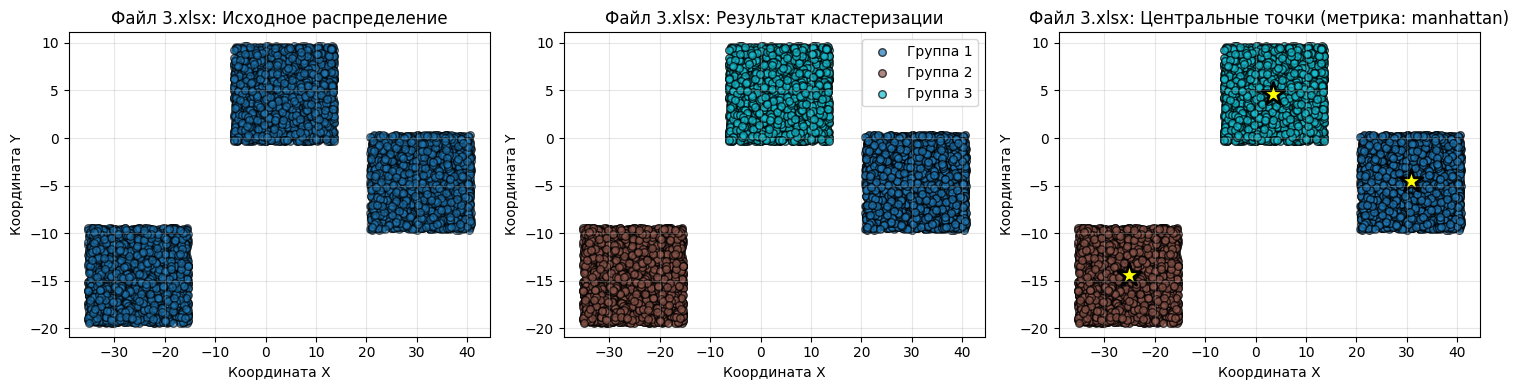


ИТОГОВЫЕ РЕЗУЛЬТАТЫ
  Среднее значение центроидов: (3.037614, -4.798146)
  Умноженное на 1000: (3037.61, -4798.15)


In [5]:
process_clustering(pd.read_excel("3.xlsx"), 'manhattan', "3.xlsx", 3)

Анализируемый набор содержит 500 точек

АНАЛИЗ КЛАСТЕРОВ ДЛЯ 4.xlsx

▶ Группа 1:
  Количество элементов: 250
  Наиболее центральная точка: (4.4993, 2.5248)
  Суммарное расстояние до остальных: 470.3286

▶ Группа 2:
  Количество элементов: 250
  Наиболее центральная точка: (0.6778, 7.4683)
  Суммарное расстояние до остальных: 460.4683


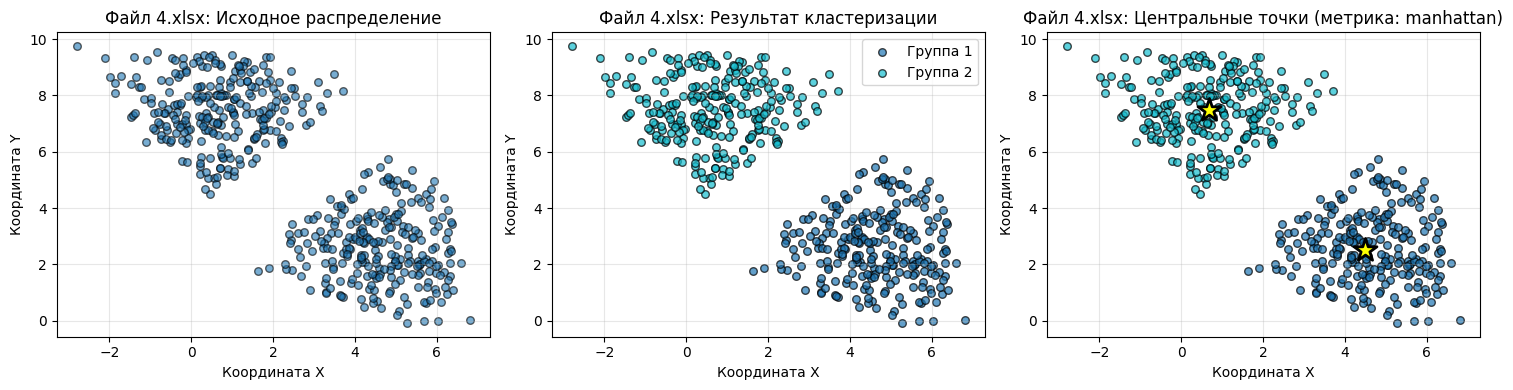


ИТОГОВЫЕ РЕЗУЛЬТАТЫ
  Среднее значение центроидов: (2.631119, 5.048732)
  Умноженное на 1000: (2631.12, 5048.73)


In [6]:
process_clustering(pd.read_excel("4.xlsx"), 'manhattan', "4.xlsx", 2)

Анализируемый набор содержит 9999 точек

АНАЛИЗ КЛАСТЕРОВ ДЛЯ 5.xlsx

▶ Группа 1:
  Количество элементов: 3333
  Наиболее центральная точка: (3.8586, 2.9072)
  Суммарное расстояние до остальных: 4958.9242

▶ Группа 2:
  Количество элементов: 3339
  Наиболее центральная точка: (-2.7497, 1.1431)
  Суммарное расстояние до остальных: 4522.4469

▶ Группа 3:
  Количество элементов: 3327
  Наиболее центральная точка: (-0.9240, 7.1199)
  Суммарное расстояние до остальных: 4955.9081


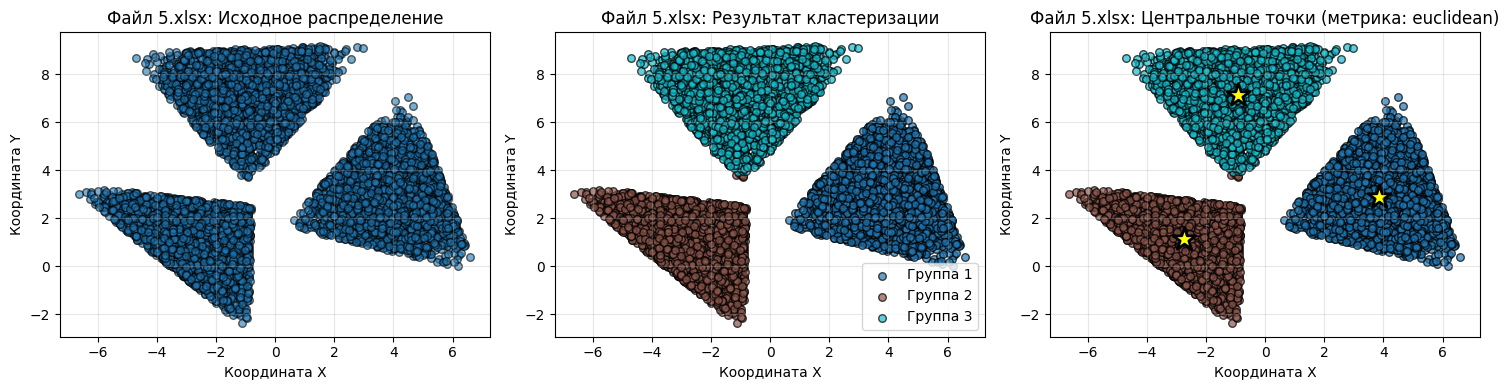


ИТОГОВЫЕ РЕЗУЛЬТАТЫ
  Среднее значение центроидов: (0.063196, 3.744630)
  Умноженное на 1000: (63.20, 3744.63)


In [7]:
process_clustering(pd.read_excel("5.xlsx"), 'euclidean', "5.xlsx", 3)

# Кластеризация (0.75 за каждый алгоритм на всех данных)

На предложенных распределениях данных проверьте предложенные алгоритмы. Постройте графики кластеризации для каждой пары алгоритм-данные, разные кластеры покрасьте разным цветом. Воспользуйтесь sklearn реализациями. Параметры кластеризации для разных алгоритмов подберите такие, чтобы алгоритмы можно было сравнивать (по возможности одинаковое количество кластеров и т.д.)

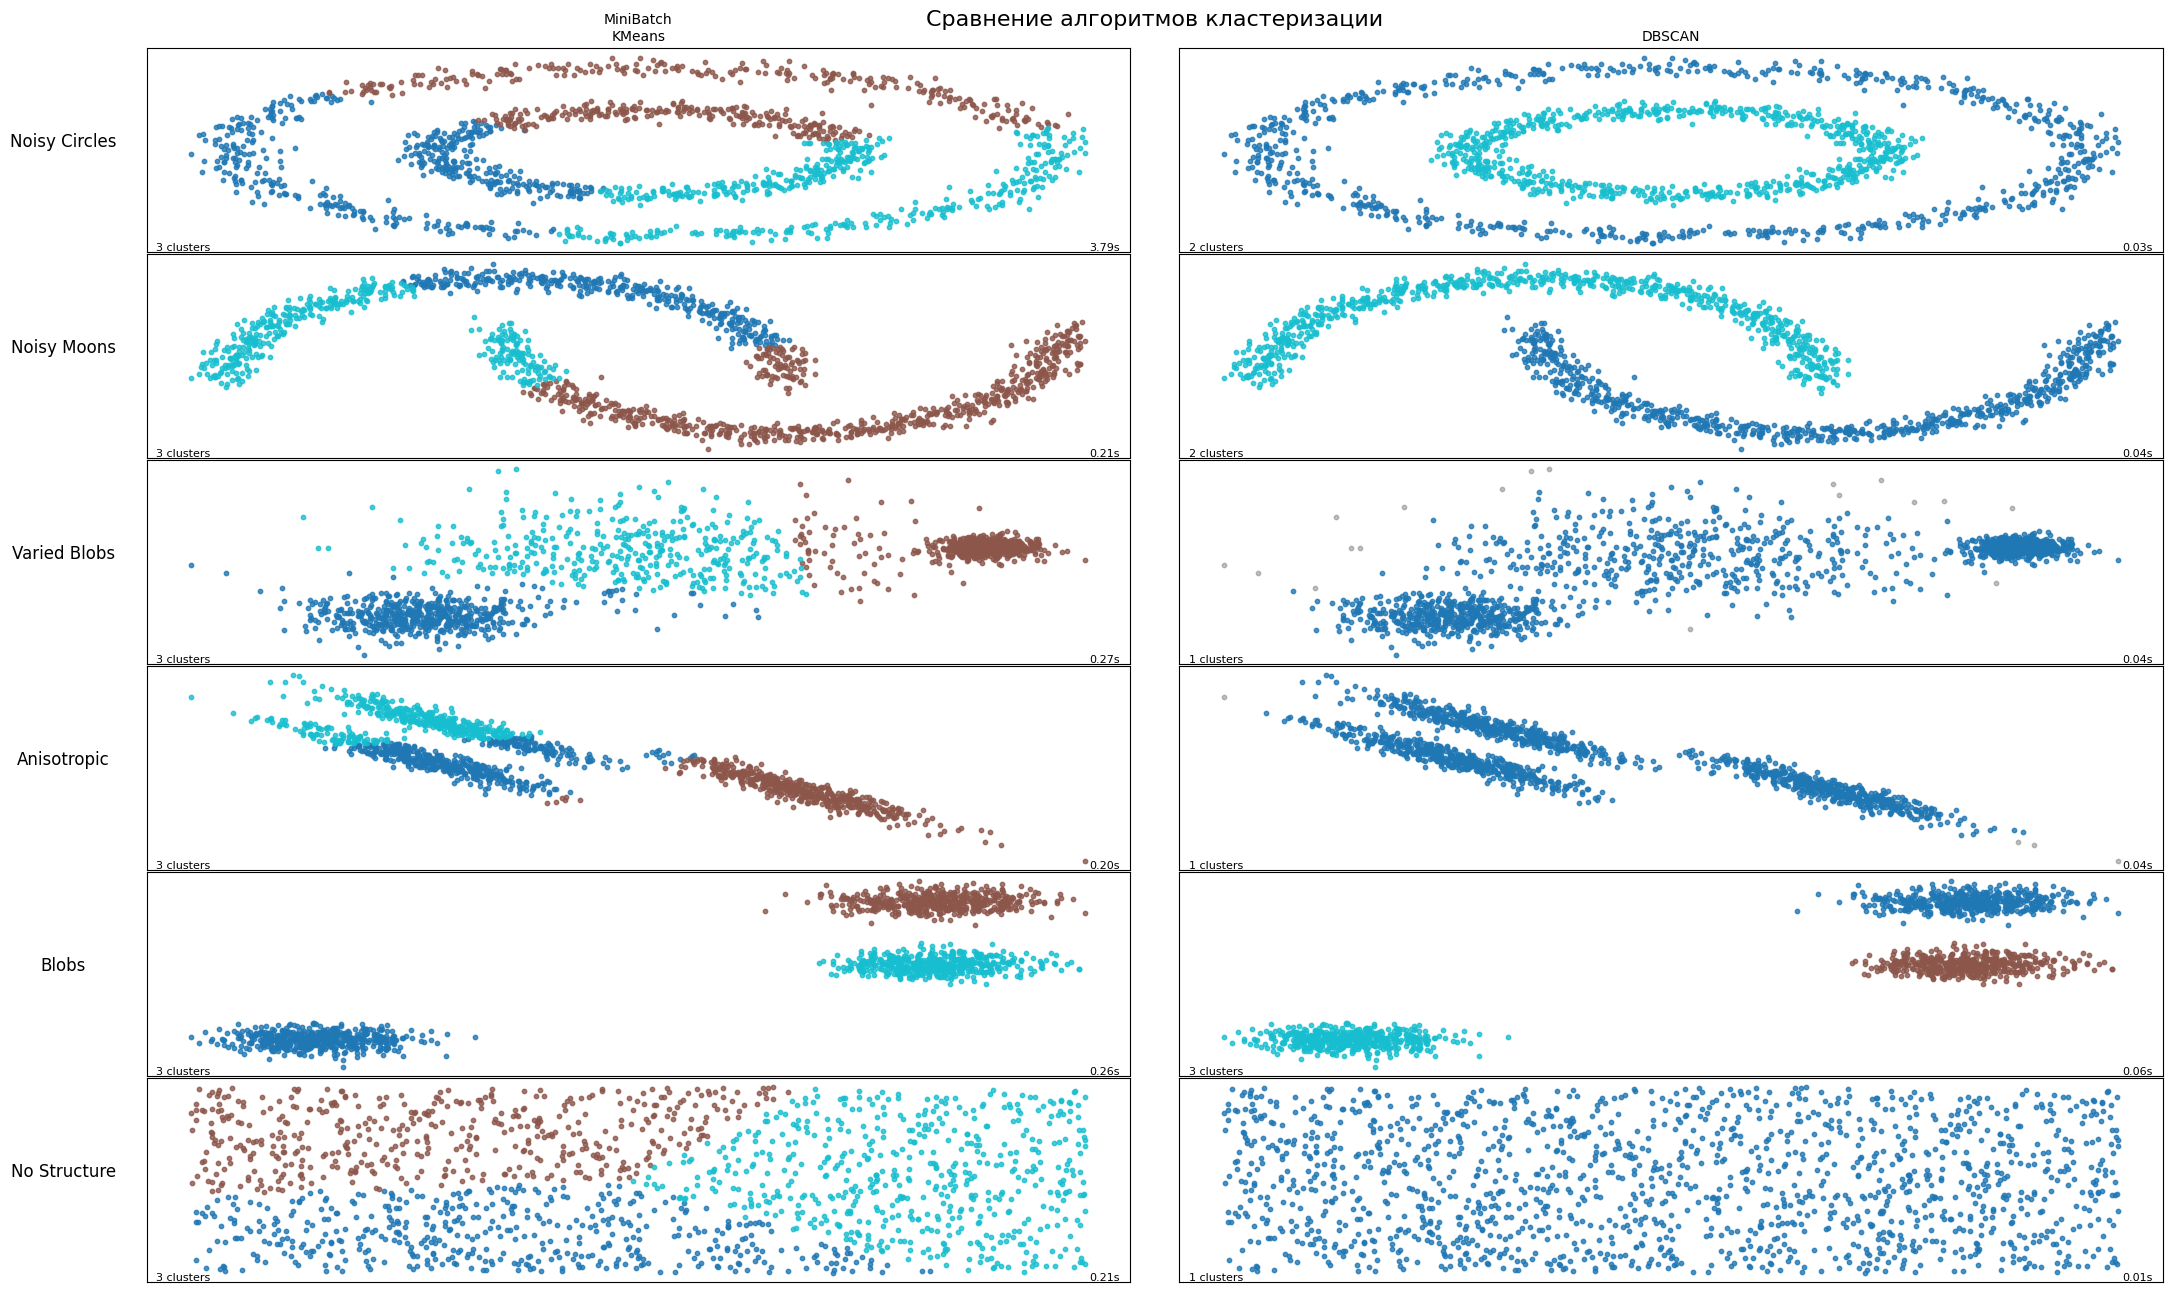

In [8]:
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.cluster import MiniBatchKMeans, DBSCAN

two_means = MiniBatchKMeans(n_clusters=3, random_state=0)
dbscan = cluster.DBSCAN(eps=0.3)

clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("DBSCAN", dbscan),
    )

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
    (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    X = StandardScaler().fit_transform(X)
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    connectivity = 0.5 * (connectivity + connectivity.T)

    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)
        
        t1 = time.time()
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        
        if i_dataset == 0:
            plt.title(name, size=10)
        
        colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(y_pred))))
        
        if name == "DBSCAN":
            noise_mask = y_pred == -1
            if np.any(noise_mask):
                plt.scatter(X[noise_mask, 0], X[noise_mask, 1], 
                           s=10, color='gray', alpha=0.5, label='Noise')
            
            for k, color in zip(np.unique(y_pred[y_pred != -1]), colors):
                if k == -1:
                    continue
                class_member_mask = y_pred == k
                xy = X[class_member_mask]
                plt.scatter(xy[:, 0], xy[:, 1], s=10, color=color, 
                           alpha=0.8, label=f'Cluster {k}')
        else:
            for k, color in zip(np.unique(y_pred), colors):
                class_member_mask = y_pred == k
                xy = X[class_member_mask]
                plt.scatter(xy[:, 0], xy[:, 1], s=10, color=color, 
                           alpha=0.8, label=f'Cluster {k}')
        
        plt.text(0.99, 0.01, f'{t1 - t0:.2f}s',
                transform=plt.gca().transAxes, size=8,
                horizontalalignment='right')
        
        if name == "DBSCAN":
            n_clusters = len(np.unique(y_pred[y_pred != -1]))
        else:
            n_clusters = len(np.unique(y_pred))
        
        plt.text(0.01, 0.01, f'{n_clusters} clusters',
                transform=plt.gca().transAxes, size=8,
                horizontalalignment='left')
        
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

dataset_names = [
    "Noisy Circles",
    "Noisy Moons",
    "Varied Blobs",
    "Anisotropic",
    "Blobs",
    "No Structure"
]

for i, name in enumerate(dataset_names):
    plt.subplot(len(datasets), len(clustering_algorithms), i * len(clustering_algorithms) + 1)
    plt.ylabel(name, rotation=0, size=12, labelpad=60)
    plt.yticks(())
    plt.xticks(())

plt.suptitle("Сравнение алгоритмов кластеризации", size=16, y=0.98)
plt.show()